### Importering av bibliotek

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import spectrogram

### Funksjoner

In [23]:
def calibrate_wavelengths(ImageWidth, Spectral_lines, Pixel_positions, Degree, Output_file):
    """
    Calibrate pixel positions to wavelengths.

    Parameters:
    - ImageWidth: int, number of pixels.
    - Spectral_lines: list of float, spectral lines or known wavelengths in nm.
    - Pixel_positions: list of int, pixel positions corresponding to the known spectral lines.
    - Degree: int, degree of the polynomial fit (1 for linear).
    - Output_file: str, path to the output CSV file.

    Returns:
    - df: pandas DataFrame, containing pixel positions and calibrated wavelengths.
    """
    if len(Spectral_lines) != len(Pixel_positions):
        raise ValueError("The number of wavelengths must match the number of pixel positions.")
    if len(Spectral_lines) < 2:
        raise ValueError("At least two wavelengths and pixel positions are required for calibration.")

    # Fit a polynomial function to the known wavelengths at the pixel positions
    wavelength_fit = np.polyfit(Pixel_positions, Spectral_lines, Degree)
    wavelength_calibration = np.poly1d(wavelength_fit)

    # Calibrate the pixel positions to wavelengths
    calibrated_wavelengths = wavelength_calibration(np.arange(ImageWidth))

    # Create a DataFrame
    df = pd.DataFrame({
        'Pixel Position': np.arange(len(calibrated_wavelengths)),
        'Calibrated Wavelength (nm)': calibrated_wavelengths
    })

    # Save the DataFrame to a CSV file
    df.to_csv(Output_file, index=False)
    return df

def expected_irradiance(B_0,r_0):
    R = 0.5 # from source to lambertian surface
    alpha = 0 # angle between source and normal to lambert
    p = 0.98 # diffusion coefficient of lambertian surface
    B_expected = B_0*(r_0/R)**2*p*np.cos(alpha) # photons/cm^2/s/Å

    return B_expected


### Bølgelengde Kalibrering

In [24]:
ImageWidth = 1024
Spectral_lines = [656.3, 486.1, 546.1, 502.5] # Hydrogen (H), Helium (He), Mercury (Hg)
pixel_positions = [100, 300, 500, 700]
degree = 2
output_file = 'Data/calibrated_wavelengths.csv'

df = calibrate_wavelengths(ImageWidth, Spectral_lines, pixel_positions, degree, output_file)
wavelengths = np.loadtxt(output_file, delimiter=',', skiprows=1, usecols=1)

#print(wavelengths)
print(df.to_string(index=False))

 Pixel Position  Calibrated Wavelength (nm)
              0                  715.067500
              1                  714.234591
              2                  713.403265
              3                  712.573521
              4                  711.745360
              5                  710.918781
              6                  710.093785
              7                  709.270371
              8                  708.448540
              9                  707.628291
             10                  706.809625
             11                  705.992541
             12                  705.177040
             13                  704.363121
             14                  703.550785
             15                  702.740031
             16                  701.930860
             17                  701.123271
             18                  700.317265
             19                  699.512841
             20                  698.710000
             21                 

### Intensitet Kalibrering

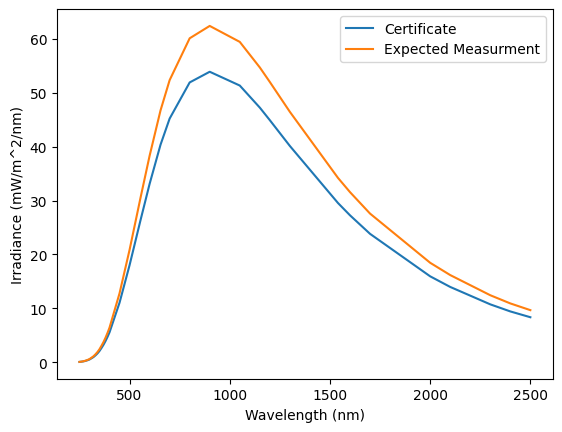

In [29]:
#Measured data
#B_measured = np.loadtxt('Data/measured.csv', delimiter=',', skiprows=1, usecols=1) # photons/cm^2/s/Å
#B_0 = np.loadtxt('Data/B0.csv', delimiter=',', skiprows=1, usecols=0) # photons/cm^2/s/Å

#Certificate data
W_L = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=0) # Wavelengths in nm
B_0 = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=1) # Irradiance in mW/m^2/nm
sigma = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=2) # Uncertainty in %

r_0 = 1
ImageHeight = 256
dist = 0.92
B_expected = expected_irradiance(B_0,r_0)

# plot B_0
plt.figure()
plt.plot(W_L,B_0, label='Certificate')
plt.plot(W_L,B_expected, label='Expected Measurment')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (mW/m^2/nm)')
plt.legend()
plt.show()


